---
**License**

 stats_dist_rosenbrock

 Mon Jan 25 20:56:00 2020\
 Copyright  2021\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 stats_dist_rosenbrock\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>


 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
import gi

gi.require_version("NumCosmo", "1.0")
gi.require_version("NumCosmoMath", "1.0")

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import numpy as np
import scipy.stats
from scipy.optimize import minimize
from pylab import figure, cm

from IPython.display import HTML, display
import tabulate

from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

from numcosmo_py.plotting.tools import confidence_ellipse

%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [3]:
dim = 2
nps = 160

split_fraction = 0.6

rng = Ncm.RNG.seeded_new(None, 123)

sigma1 = math.sqrt(10.0)
sigma2 = 1.0 / sigma1
mu1 = 1.0


def m2lnL_val(va):
    return (mu1 - va[0]) ** 2 / sigma1**2 + (va[1] - va[0] ** 2) ** 2 / sigma2**2

In [4]:
interps = []
interps_desc = []

kernel0 = Ncm.StatsDistKernelST.new(dim, 1.0)
interp0 = Ncm.StatsDistKDE.new(kernel0, Ncm.StatsDistCV.NONE)
interps.append(interp0)
interps_desc.append("KDE Cauchy")

kernel1 = Ncm.StatsDistKernelST.new(dim, 3.0)
interp1 = Ncm.StatsDistKDE.new(kernel1, Ncm.StatsDistCV.NONE)
interps.append(interp1)
interps_desc.append("KDE ST3")

kernel2 = Ncm.StatsDistKernelGauss.new(dim)
interp2 = Ncm.StatsDistKDE.new(kernel2, Ncm.StatsDistCV.NONE)
interps.append(interp2)
interps_desc.append("KDE Gauss")

kernel3 = Ncm.StatsDistKernelST.new(dim, 1.0)
interp3 = Ncm.StatsDistVKDE.new(kernel3, Ncm.StatsDistCV.NONE)
interps.append(interp3)
interps_desc.append("VKDE Cauchy")

kernel4 = Ncm.StatsDistKernelST.new(dim, 3.0)
interp4 = Ncm.StatsDistVKDE.new(kernel4, Ncm.StatsDistCV.NONE)
interps.append(interp4)
interps_desc.append("VKDE ST3")

kernel5 = Ncm.StatsDistKernelGauss.new(dim)
interp5 = Ncm.StatsDistVKDE.new(kernel5, Ncm.StatsDistCV.NONE)
interps.append(interp5)
interps_desc.append("VKDE Gauss")

In [5]:
for interp in interps:
    interp.reset()

theta_train = []  # Training set variables
m2lnp_train = []  # Training set m2lnp

for i in range(nps):
    x1 = rng.gaussian_gen(mu1, sigma1)
    x2 = rng.gaussian_gen(x1 * x1, sigma2)

    theta_i = [x1, x2]
    m2lnp_i = m2lnL_val(theta_i)

    theta_train.append(theta_i)
    m2lnp_train.append(m2lnp_i)

    theta_v_i = Ncm.Vector.new_array(theta_i)
    for interp in interps:
        interp.add_obs(theta_v_i)

theta_train = np.array(theta_train)
m2lnp_train = np.array(m2lnp_train)
m2lnp_train_v = Ncm.Vector.new_array(m2lnp_train)

theta_test = []  # Test set variables
m2lnp_test = []  # Test set m2lnp

for i in range(10 * nps):
    x1 = rng.gaussian_gen(mu1, sigma1)
    x2 = rng.gaussian_gen(x1 * x1, sigma2)

    theta_i = [x1, x2]
    m2lnp_i = m2lnL_val(theta_i)

    theta_test.append(theta_i)
    m2lnp_test.append(m2lnp_i)

    theta_v_i = Ncm.Vector.new_array(theta_i)

theta_test = np.array(theta_test)
m2lnp_test = np.array(m2lnp_test)

In [6]:
for interp in interps:
    interp.set_cv_type(Ncm.StatsDistCV.SPLIT)
    interp.set_split_frac(split_fraction)
    interp.set_print_fit(False)

    interp.prepare_interp(m2lnp_train_v)
    calib_os = interp.get_over_smooth()

    print(
        "Calibrate interpolation with os = % 22.15g and rnorm = % 22.15g"
        % (calib_os, interp.get_rnorm())
    )

Calibrate interpolation with os =     0.0472224146826804 and rnorm =       50.4910675203372
Calibrate interpolation with os =      0.066240955299399 and rnorm =       40.4255898945536
Calibrate interpolation with os =     0.0521711381377012 and rnorm =       30.7699474475816
Calibrate interpolation with os =     0.0846228165389075 and rnorm =       51.2404586719154
Calibrate interpolation with os =       0.13226060005939 and rnorm =       33.6968184699468
Calibrate interpolation with os =       0.13903315848851 and rnorm =       20.1956808878481


In [7]:
m2lnp_interps = []

for interp in interps:
    m2lnp_interp = []
    for theta in theta_test:
        m2lnp_interp.append(interp.eval_m2lnp(Ncm.Vector.new_array(theta)))
    m2lnp_interp = np.array(m2lnp_interp)

    m2lnp_interps.append(m2lnp_interp)

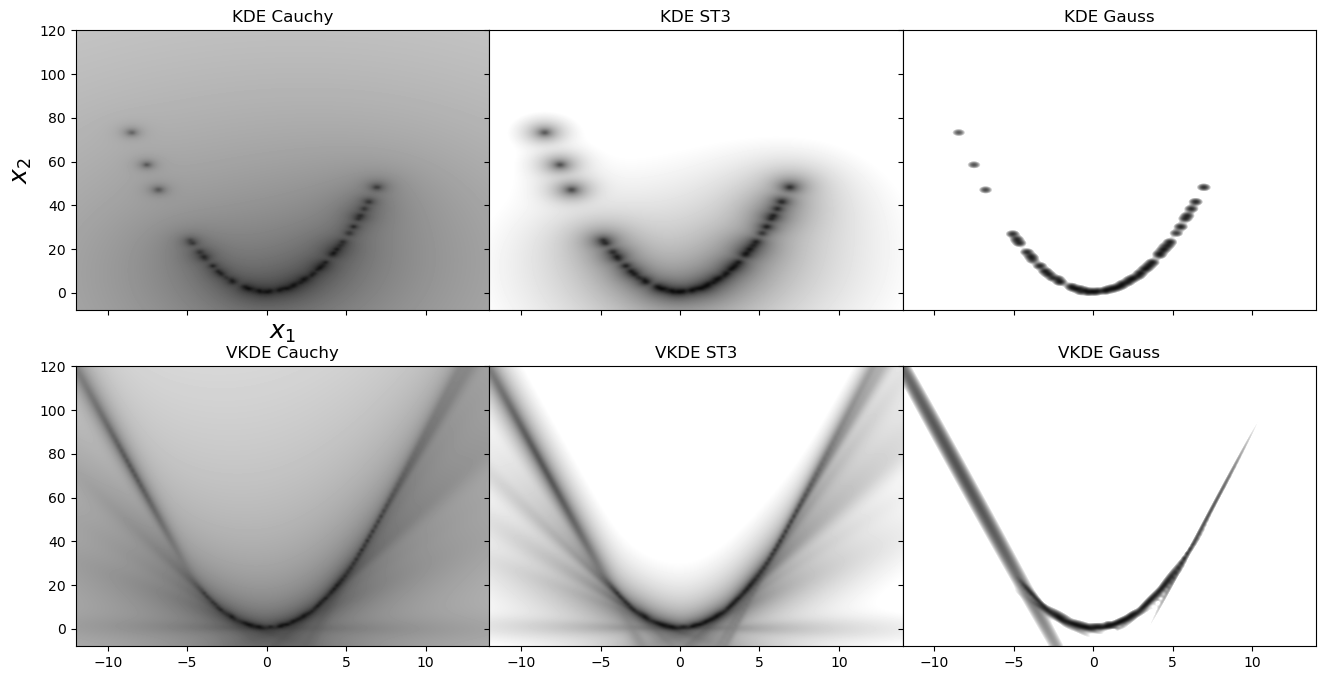

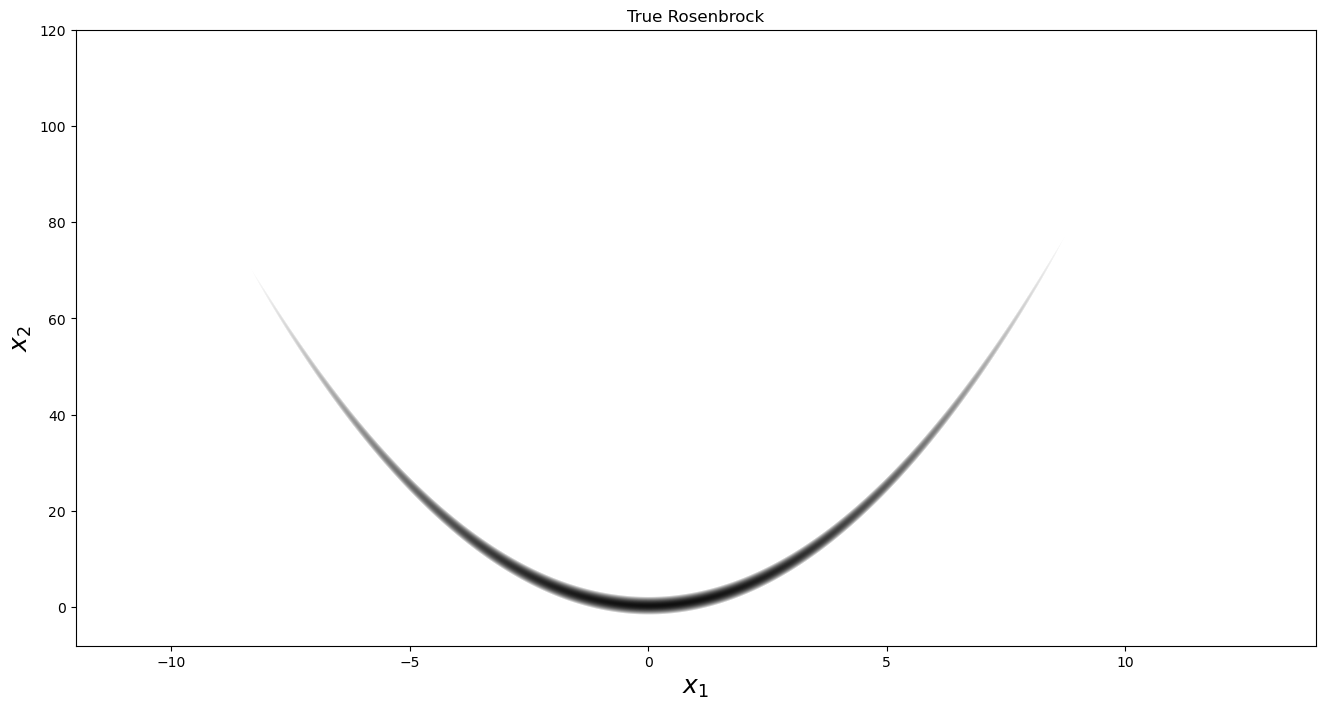

In [8]:
plotn = 150

fig, axa = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey=True)
axa = [ax for subaxa in axa for ax in subaxa]

x1_a = np.linspace(-12, 14, plotn)
x2_a = np.linspace(-8, 120, plotn)

for interp, interp_desc, ax0 in zip(interps, interps_desc, axa):

    z = np.array(
        [
            interp.eval_m2lnp(Ncm.Vector.new_array([x1, x2]))
            for x2 in x2_a
            for x1 in x1_a
        ]
    )
    z = z - min(z)
    Z = z.reshape(plotn, plotn)

    ax0.imshow(
        Z,
        interpolation="bicubic",
        origin="lower",
        cmap=cm.gray,
        norm=Normalize(vmin=0.0, vmax=40),
        extent=[x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]],
        aspect="auto",
    )
    ax0.set_title(interp_desc)
    if interp_desc == "KDE Cauchy":
        ax0.set_xlabel("$x_1$", fontsize=18)
        ax0.set_ylabel("$x_2$", fontsize=18)


plt.subplots_adjust(wspace=0.0, hspace=0.2)
plt.show()

plt.figure(figsize=(16, 8))

zT = np.array([m2lnL_val([x1, x2]) for x2 in x2_a for x1 in x1_a])
ZT = zT.reshape(plotn, plotn)
plt.imshow(
    ZT,
    interpolation="bicubic",
    origin="lower",
    cmap=cm.gray,
    norm=Normalize(vmin=0.0, vmax=40),
    extent=[x1_a[0], x1_a[-1], x2_a[0], x2_a[-1]],
    aspect="auto",
)
plt.title("True Rosenbrock")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18)

pass

In [9]:
table = [
    [
        "Interpolation type",
        "relative difference",
        "acceptance probability",
        "split fraction",
    ]
]

rel_diff_array = []
prob_array = []

for interp, interp_desc, m2lnp_interp in zip(interps, interps_desc, m2lnp_interps):

    p_test = np.exp(-0.5 * m2lnp_test)
    p_interp = np.exp(-0.5 * m2lnp_interp)

    log_diff = m2lnp_interp - m2lnp_test
    rel_diff = np.abs(np.expm1(-0.5 * log_diff))

    prob_ratio = -0.5 * (
        (m2lnp_interp[0::2] - m2lnp_test[0::2])
        - (m2lnp_interp[1::2] - m2lnp_test[1::2])
    )
    prob_ratio = np.clip(0, 10.0, prob_ratio)

    prob = np.minimum(np.exp(prob_ratio), 1.0)

    rel_diff_array.append(rel_diff)
    prob_array.append(prob)

    qp = [0.25, 0.75]

    q_rel_diff = np.quantile(rel_diff, qp) * 100.0
    q_prob = np.quantile(prob, qp) * 100.0

    line = [interp_desc]
    line.append("%.1f%% - %.1f%%" % (q_rel_diff[0], q_rel_diff[1]))
    line.append("%.1f%% - %.1f%%" % (q_prob[0], q_prob[1]))
    line.append("%.1f%%" % (split_fraction * 100.0))
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt="html")))

Interpolation type,relative difference,acceptance probability,split fraction
KDE Cauchy,66.7% - 96.6%,17.5% - 100.0%,60.0%
KDE ST3,35.4% - 93.5%,17.3% - 100.0%,60.0%
KDE Gauss,23.2% - 93.0%,19.3% - 100.0%,60.0%
VKDE Cauchy,58.5% - 91.8%,27.6% - 100.0%,60.0%
VKDE ST3,18.5% - 77.3%,36.9% - 100.0%,60.0%
VKDE Gauss,13.7% - 60.6%,51.9% - 100.0%,60.0%


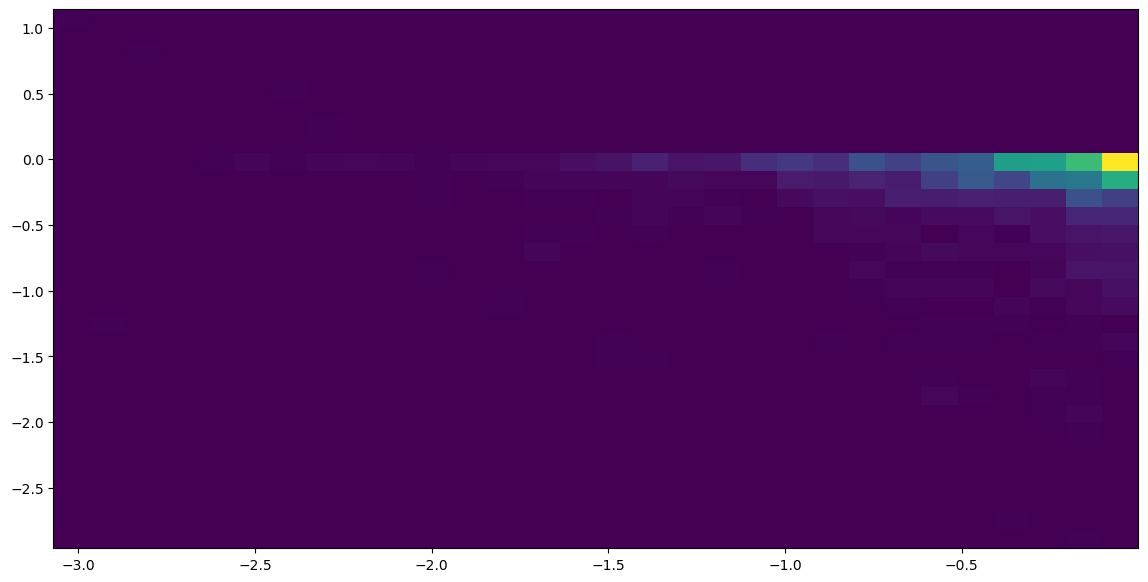

In [10]:
plt.figure(figsize=(14, 7))

plt.hist2d(np.log10(p_test), np.log10(rel_diff_array[0]), bins=30)
plt.hist2d(np.log10(p_test), np.log10(rel_diff_array[1]), bins=30)
plt.hist2d(np.log10(p_test), np.log10(rel_diff_array[2]), bins=30)
plt.hist2d(np.log10(p_test), np.log10(rel_diff_array[3]), bins=30)
pass

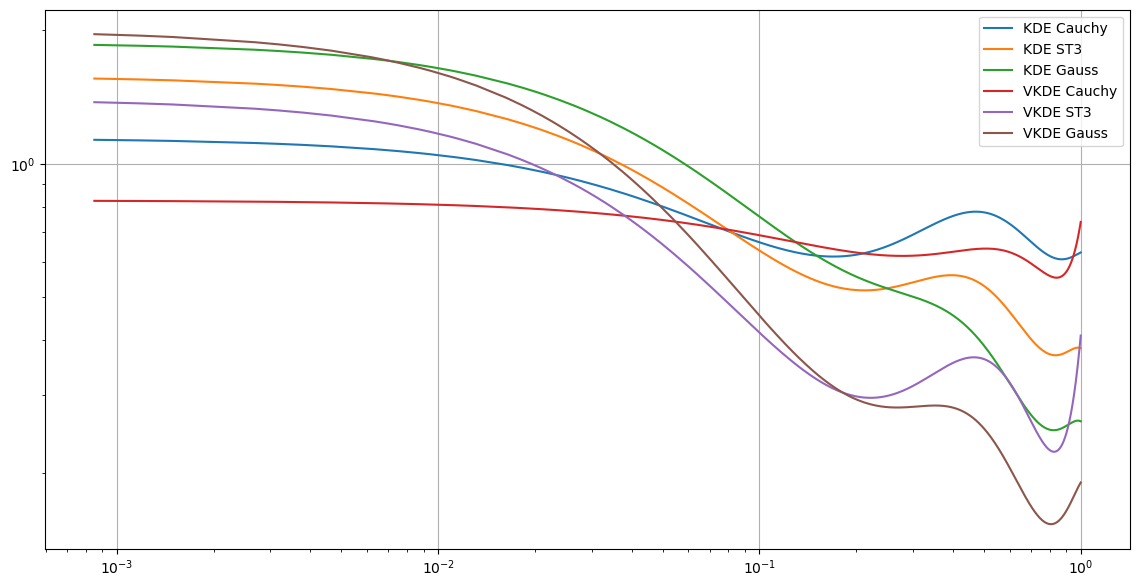

In [11]:
plt.figure(figsize=(14, 7))

index_array = np.argsort(p_test)
x = p_test[index_array]

for desc, rel_diff in zip(interps_desc, rel_diff_array):
    y = np.log(np.abs(rel_diff[index_array]))

    z = np.polyfit(x, y, 5)
    p = np.poly1d(z)

    yhat = [p(x_i) for x_i in x]

    plt.plot(x, np.exp(yhat), label=desc)
    # plt.scatter(x, np.exp(y), s=0.1)

plt.grid()
plt.legend(loc="best")
plt.xscale("log")
plt.yscale("log")

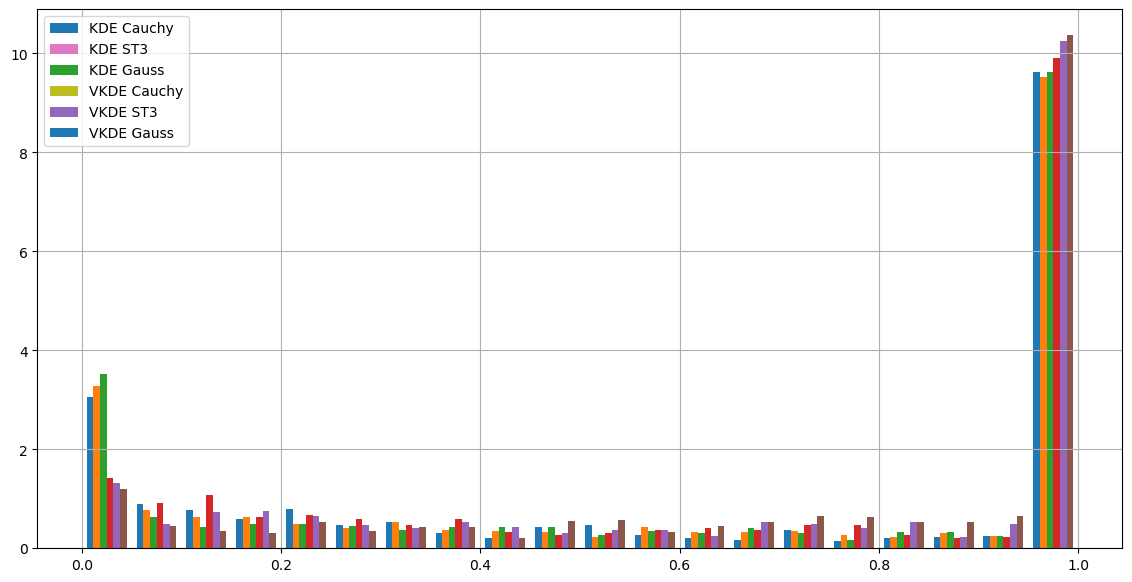

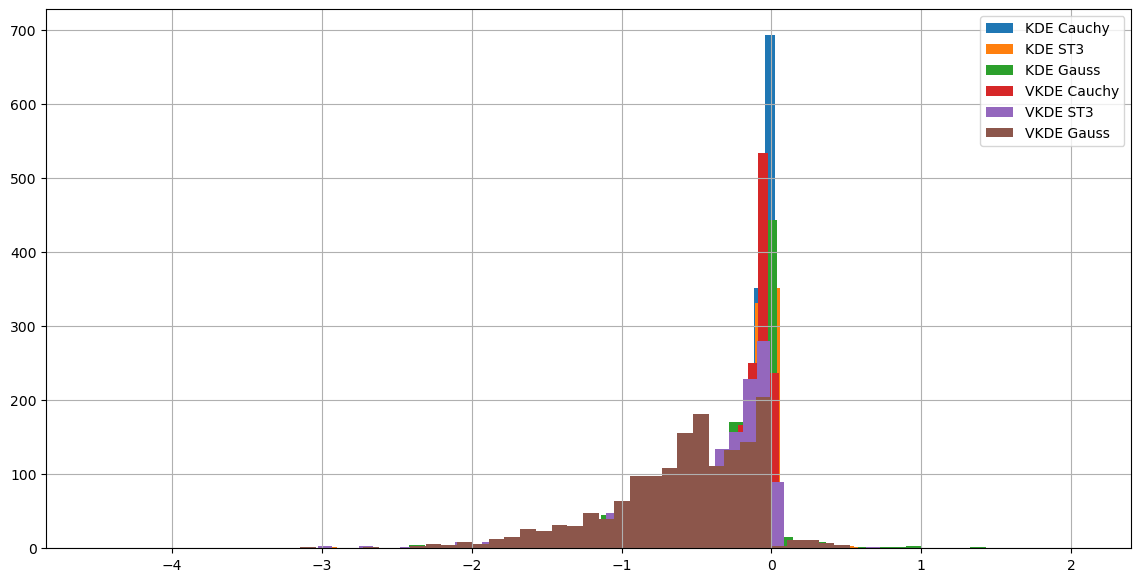

In [12]:
plt.figure(figsize=(14, 7))

for diff, prob, interp_desc in zip(rel_diff_array, prob_array, interps_desc):
    plt.hist(prob_array, label=interp_desc, bins=20, density=True)
plt.grid()
plt.legend(loc="best")
plt.show()

plt.figure(figsize=(14, 7))

for diff, prob, interp_desc in zip(rel_diff_array, prob_array, interps_desc):
    plt.hist(np.log10(np.abs(diff)), bins=60, label=interp_desc)
    # plt.hist (np.log10 (np.abs (exp_diff)), bins = 60, label=r'$|y_i/y_a - 1|$')

plt.grid()
plt.legend(loc="best")
plt.show()


pass

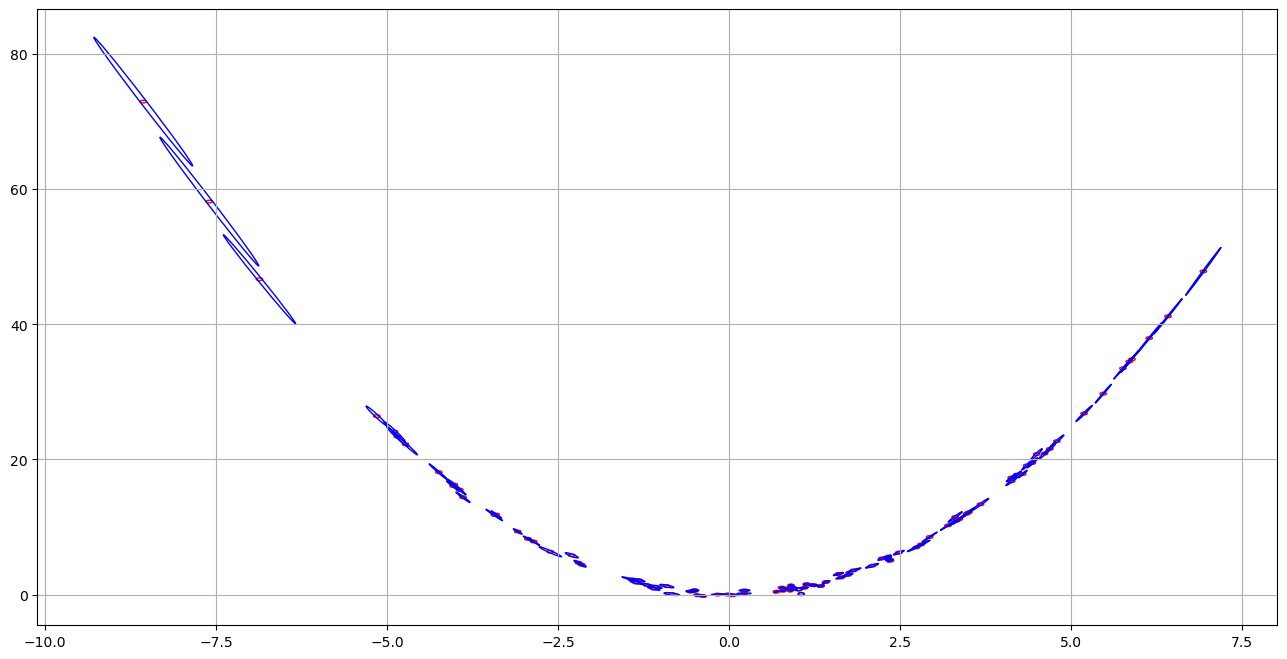

In [13]:
#
#    y_i, cov_i, n_i, w_i = interp.get_Ki (i)
#    print (n_i, w_i)
#    cov_i.log_vals ("COV: ", "%f")

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(0, interps[0].get_n_kernels()):
    y_i, cov_i, n_i, w_i = interps[0].get_Ki(i)
    mu = y_i.dup_array()
    cov = np.array([[cov_i.get(i, j) for j in range(2)] for i in range(2)])
    cov = cov * 1.0

    confidence_ellipse(mu, cov, ax, edgecolor="red")

for i in range(0, interps[3].get_n_kernels()):
    y_i, cov_i, n_i, w_i = interps[3].get_Ki(i)
    mu = y_i.dup_array()
    cov = np.array([[cov_i.get(i, j) for j in range(2)] for i in range(2)])
    cov = cov * 1.0

    confidence_ellipse(mu, cov, ax, edgecolor="blue")

ax.autoscale_view()
plt.grid()